# Setup

In [2]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-geometric

Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu111.html
Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu111.html


In [82]:
import random
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim, Tensor

from torch_sparse import SparseTensor, matmul

from torch_geometric.utils import structured_negative_sampling
from torch_geometric.data import download_url, extract_zip
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.typing import Adj

# Dataset

In [83]:
url="/content/data"
movie_path="/content/data/movies.csv"
rating_path="/content/data/ratings.csv"


In [84]:
rating_df = pd.read_csv(rating_path)
print(rating_df.head())
print(len(rating_df['movieId'].unique()))
print(len(rating_df['userId'].unique()))
rating_df.describe()

   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931
9724
610


,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [85]:
# Import pandas library
import pandas as pd

# Define the movies variable
movies = pd.read_csv("/content/data/movies.csv")

# Read the ratings data
ratings = pd.read_csv(rating_path)

# Display sample data
print("Movies Data:")
print(movies.head())
print("Ratings Data:")
print(ratings.head())


Movies Data:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
Ratings Data:
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


In [86]:
# Create a user-item interaction matrix
user_item_matrix = ratings.pivot(index='userId', columns='movieId', values='rating')
user_item_matrix = user_item_matrix.fillna(0)  # Fill NaN values with 0

# Display the user-item interaction matrix
print("\nUser-Item Interaction Matrix:")
print(user_item_matrix.head())


User-Item Interaction Matrix:
movieId  1       2       3       4       5       6       7       8       \
userId                                                                    
1           4.0     0.0     4.0     0.0     0.0     4.0     0.0     0.0   
2           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
5           4.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

movieId  9       10      ...  193565  193567  193571  193573  193579  193581  \
userId                   ...                                                   
1           0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
2           0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
3           0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
4           0.0     0.0  ...     0.0     0.

In [87]:
# Split the data into training and testing sets
train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=42)

# Display the shapes of the training and testing sets
print("\nShapes of Training and Testing Sets:")
print("Training set:", train_data.shape)
print("Testing set:", test_data.shape)


Shapes of Training and Testing Sets:
Training set: (80668, 4)
Testing set: (20168, 4)


In [88]:
movies = pd.DataFrame(movies)
print("Movie Data:")
unique_movie_ids = ratings['movieId'].nunique()
print("Total number of unique movie IDs:", unique_movie_ids)

print("Number of Rows:", movies.shape[0])
print("Number of Columns:", movies.shape[1])

print("\nRatings Data:")
print("Number of Rows:", ratings.shape[0])
print("Number of Columns:", ratings.shape[1])

Movie Data:
Total number of unique movie IDs: 9724
Number of Rows: 9742
Number of Columns: 3

Ratings Data:
Number of Rows: 100836
Number of Columns: 4


In [89]:
from sklearn import preprocessing
lbl_user = preprocessing.LabelEncoder()
lbl_movie = preprocessing.LabelEncoder()

rating_df.userId = lbl_user.fit_transform(rating_df.userId.values)
rating_df.movieId = lbl_movie.fit_transform(rating_df.movieId.values)
print(rating_df.userId)
print(rating_df.movieId)

0           0
1           0
2           0
3           0
4           0
         ... 
100831    609
100832    609
100833    609
100834    609
100835    609
Name: userId, Length: 100836, dtype: int64
0            0
1            2
2            5
3           43
4           46
          ... 
100831    9416
100832    9443
100833    9444
100834    9445
100835    9485
Name: movieId, Length: 100836, dtype: int64


In [90]:
print(rating_df.userId.max())
print(rating_df.movieId.max())

609
9723


In [91]:
rating_df.rating.value_counts()

4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: rating, dtype: int64

#Data Visualization

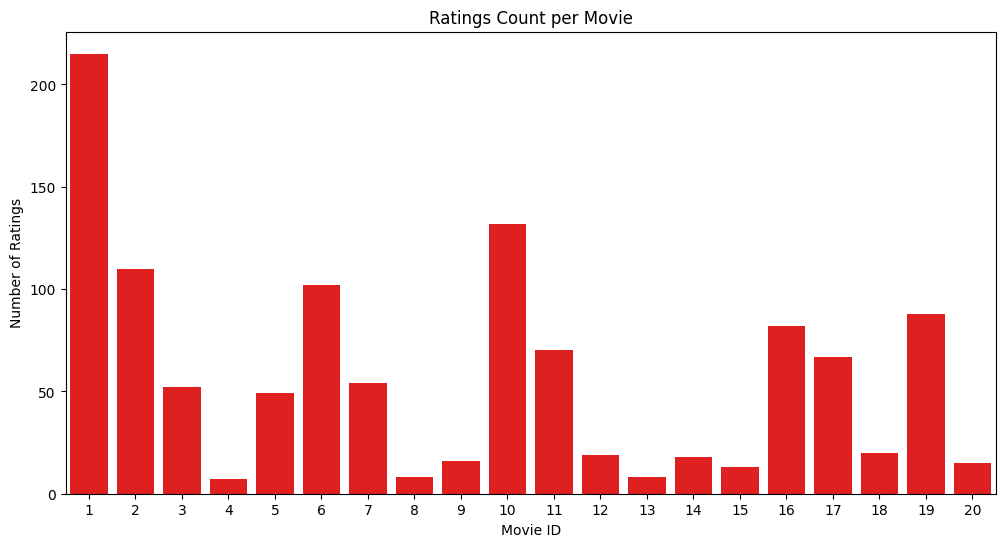

In [15]:
import seaborn as sns
#import matplotlib.pyplot as plt
movies = pd.read_csv(movie_path)
ratings = pd.read_csv(rating_path)
# Count the number of ratings per movie
ratings_per_movie = ratings.groupby('movieId').size().reset_index(name='ratings_count')

# Merge with movie data to get genres information
movies_with_ratings = pd.merge(movies, ratings_per_movie, on='movieId')

# Display a bar graph of ratings count per movie
plt.figure(figsize=(12, 6))
sns.barplot(x='movieId', y='ratings_count', data=movies_with_ratings.head(20), color='red')  # Displaying top 20 movies for example
plt.title('Ratings Count per Movie')
plt.xlabel('Movie ID')
plt.ylabel('Number of Ratings')
plt.show()

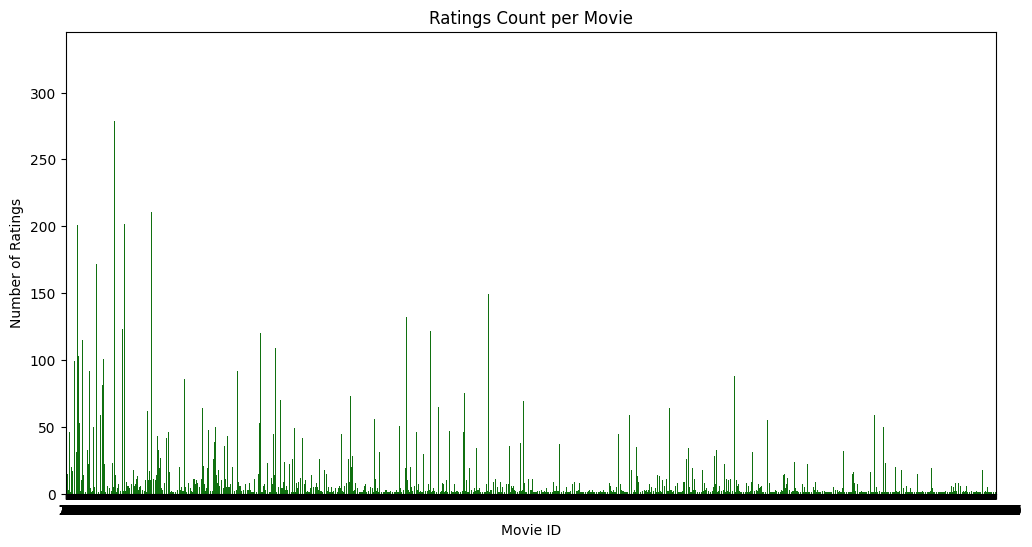

In [16]:
import seaborn as sns
movies = pd.read_csv(movie_path)
ratings = pd.read_csv(rating_path)
# Count the number of ratings per movie
ratings_per_movie = ratings.groupby('movieId').size().reset_index(name='ratings_count')

# Merge with movie data to get genres information
movies_with_ratings = pd.merge(movies, ratings_per_movie, on='movieId')

# Display a bar graph of ratings count per movie
plt.figure(figsize=(12, 6))
sns.barplot(x='movieId', y='ratings_count', data=movies_with_ratings.head(9742), color='green')  # Displaying top 20 movies for example
plt.title('Ratings Count per Movie')
plt.xlabel('Movie ID')
plt.ylabel('Number of Ratings')
plt.show()

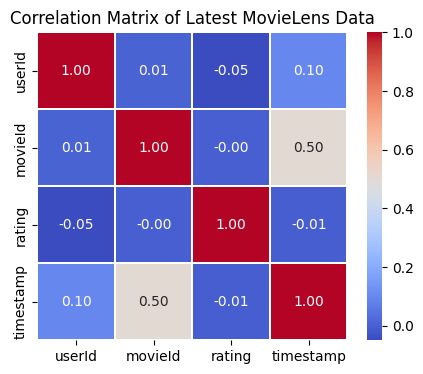

In [48]:
correlation_matrix = ratings.corr()
plt.figure(figsize=(5, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.2)
plt.title('Correlation Matrix of Latest MovieLens Data')
plt.show()

In [92]:
import pandas as pd

# Assuming movie_path is the file path to your movie data CSV
movies = pd.read_csv(movie_path)


In [93]:
import networkx as nx
G = nx.Graph()
G.add_nodes_from(movies['movieId'], bipartite=0, label='movie')
G.add_nodes_from(ratings['userId'], bipartite=1, label='user')
edges = list(zip(ratings['userId'], ratings['movieId']))
G.add_edges_from(edges)
movie_attributes = dict(zip(movies['movieId'], movies['genres']))

for movie_id, attributes in movie_attributes.items():
    G.nodes[movie_id]['genres'] = attributes


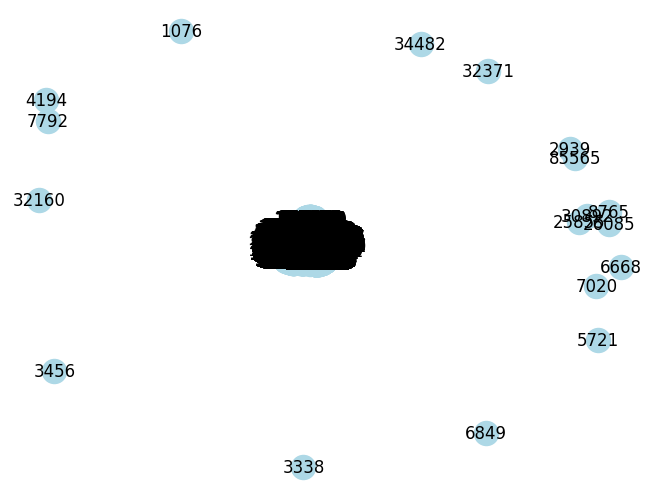

In [94]:
pos = nx.spring_layout(G)

# Draw nodes and edges
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='grey')

# Display the graph
plt.show()

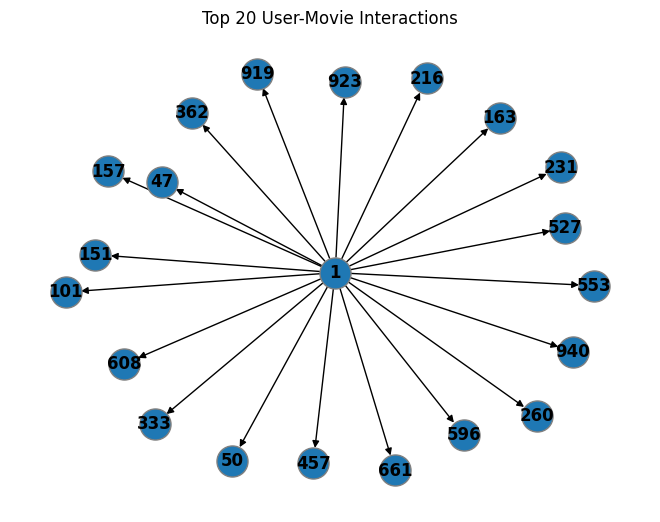

In [74]:
import networkx as nx
# Filter for top 20 interactions
top_interactions = ratings.nlargest(20, 'rating')

# Create a directed graph for clarity in interactions
G = nx.DiGraph()

# Add nodes with clear labels and colors
G.add_nodes_from(top_interactions['movieId'], bipartite=0, label='Movie', color='lightyellow')
G.add_nodes_from(top_interactions['userId'], bipartite=1, label='User', color='lightgreen')

# Add edges with clear labels and weights
edges_ratings = list(zip(top_interactions['userId'], top_interactions['movieId'], top_interactions['rating']))
G.add_weighted_edges_from(edges_ratings, weight='rating', label='rated')

# Visualize the graph with clear labels and layout
pos = nx.spring_layout(G, k=0.4)  # Adjust k for spacing
nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=500, edgecolors='gray')

# Customize edge labels for clarity
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.title("Top 20 User-Movie Interactions")
plt.show()


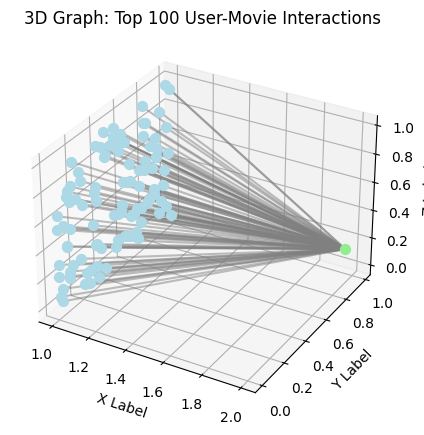

In [54]:
from mpl_toolkits.mplot3d import Axes3D
import networkx as nx

top_interactions = ratings.nlargest(100, 'rating')

# Create a directed graph
G = nx.DiGraph()

# Add nodes
G.add_nodes_from(top_interactions['movieId'], bipartite=0)
G.add_nodes_from(top_interactions['userId'], bipartite=1)

# Add edges with weights
edges_ratings = list(zip(top_interactions['userId'], top_interactions['movieId'], top_interactions['rating']))
G.add_weighted_edges_from(edges_ratings, weight='rating')

# Set positions for nodes (3D layout)
pos = {}
for node in G.nodes:
    if G.nodes[node]['bipartite'] == 0:  # Movie
        pos[node] = (1, random.uniform(0, 1), random.uniform(0, 1))
    else:  # User
        pos[node] = (2, random.uniform(0, 1), random.uniform(0, 1))

# Plot the 3D graph
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

# Draw nodes
for node, (x, y, z) in pos.items():
    color = 'lightblue' if G.nodes[node]['bipartite'] == 0 else 'lightgreen'
    ax.scatter(x, y, z, color=color, s=50)

# Draw edges
for edge in G.edges:
    x = [pos[edge[0]][0], pos[edge[1]][0]]
    y = [pos[edge[0]][1], pos[edge[1]][1]]
    z = [pos[edge[0]][2], pos[edge[1]][2]]
    ax.plot(x, y, z, color='gray', alpha=0.5)

# Set labels for axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# Display the 3D graph
plt.title('3D Graph: Top 100 User-Movie Interactions')
plt.show()


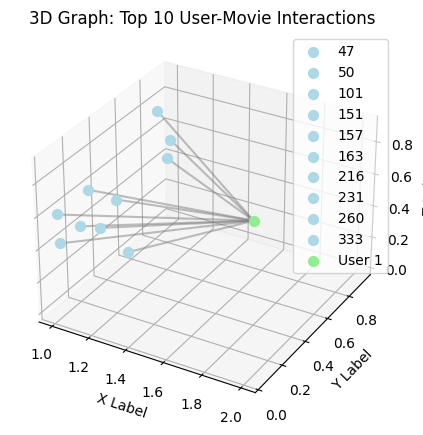

In [55]:

# Assuming you have the necessary data loaded and defined

# Filter for top 10 interactions
top_interactions = ratings.nlargest(10, 'rating')

# Create a directed graph
G = nx.DiGraph()

# Add nodes with clear labels and colors
G.add_nodes_from(top_interactions['movieId'], bipartite=0, label='Movie', color='lightblue')
G.add_nodes_from(top_interactions['userId'], bipartite=1, label='User', color='lightgreen')

# Add edges with clear labels and weights
edges_ratings = list(zip(top_interactions['userId'], top_interactions['movieId'], top_interactions['rating']))
G.add_weighted_edges_from(edges_ratings, weight='rating', label='rated')

# Set positions for nodes (3D layout)
pos = {}
for node in G.nodes:
    if G.nodes[node]['bipartite'] == 0:  # Movie
        pos[node] = (1, random.uniform(0, 1), random.uniform(0, 1))
    else:  # User
        pos[node] = (2, random.uniform(0, 1), random.uniform(0, 1))

# Plot the 3D graph
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

# Draw nodes with labels
for node, (x, y, z) in pos.items():
    label = node if G.nodes[node]['bipartite'] == 0 else f"User {node}"
    color = 'lightblue' if G.nodes[node]['bipartite'] == 0 else 'lightgreen'
    ax.scatter(x, y, z, color=color, s=50, label=label)

# Draw edges
for edge in G.edges:
    x = [pos[edge[0]][0], pos[edge[1]][0]]
    y = [pos[edge[0]][1], pos[edge[1]][1]]
    z = [pos[edge[0]][2], pos[edge[1]][2]]
    ax.plot(x, y, z, color='gray', alpha=0.5)

# Set labels for axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# Set legend
ax.legend()

# Display the 3D graph
plt.title('3D Graph: Top 10 User-Movie Interactions')
plt.show()


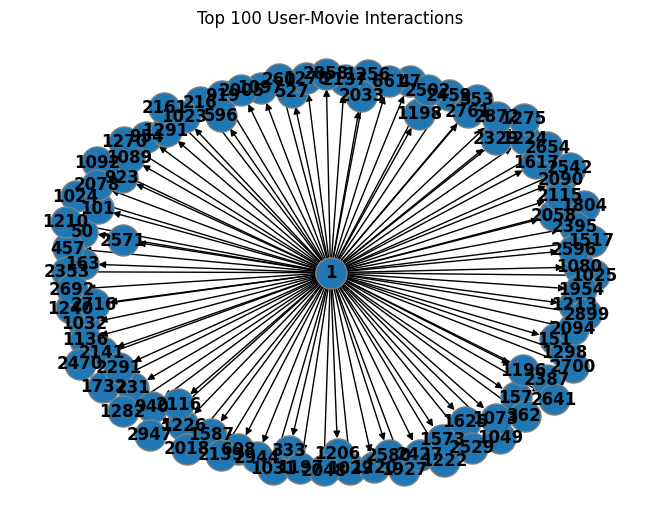

In [80]:
import networkx as nx
# Filter for top 100 interactions
top_interactions = ratings.nlargest(100, 'rating')

# Create a directed graph for clarity in interactions
G = nx.DiGraph()

# Add nodes with clear labels and colors
G.add_nodes_from(top_interactions['movieId'], bipartite=0, label='Movie', color='lightblue')
G.add_nodes_from(top_interactions['userId'], bipartite=1, label='User', color='lightgreen')

# Add edges with clear labels and weights
edges_ratings = list(zip(top_interactions['userId'], top_interactions['movieId'], top_interactions['rating']))
G.add_weighted_edges_from(edges_ratings, weight='rating', label='rated')

# Visualize the graph with clear labels and layout
pos = nx.spring_layout(G, k=0.4)  # Adjust k for spacing
nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=500, edgecolors='gray')

# Customize edge labels for clarity
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.title("Top 100 User-Movie Interactions")
plt.show()


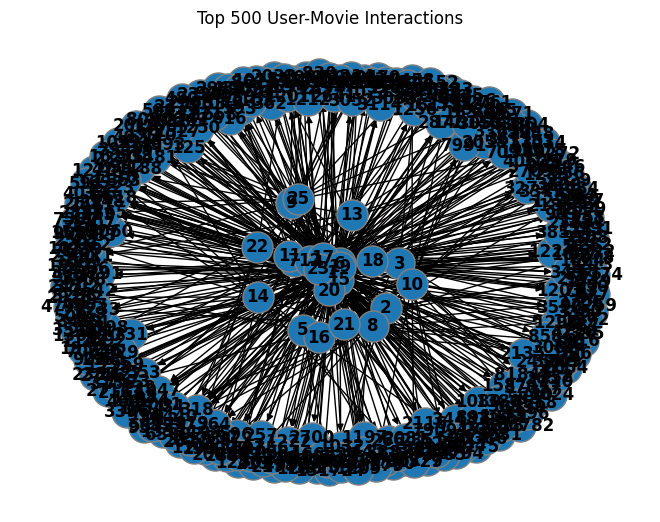

In [105]:
import networkx as nx
# Filter for top 9000 interactions
top_interactions = ratings.nlargest(500, 'rating')

# Create a directed graph for clarity in interactions
G = nx.DiGraph()

# Add nodes with clear labels and colors
G.add_nodes_from(top_interactions['movieId'], bipartite=0, label='Movie', color='lightblue')
G.add_nodes_from(top_interactions['userId'], bipartite=1, label='User', color='lightgreen')

# Add edges with clear labels and weights
edges_ratings = list(zip(top_interactions['userId'], top_interactions['movieId'], top_interactions['rating']))
G.add_weighted_edges_from(edges_ratings, weight='rating', label='rated')

# Visualize the graph with clear labels and layout
pos = nx.spring_layout(G, k=0.4)  # Adjust k for spacing
nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=500, edgecolors='gray')

# Customize edge labels for clarity
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.title("Top 500 User-Movie Interactions")
plt.show()


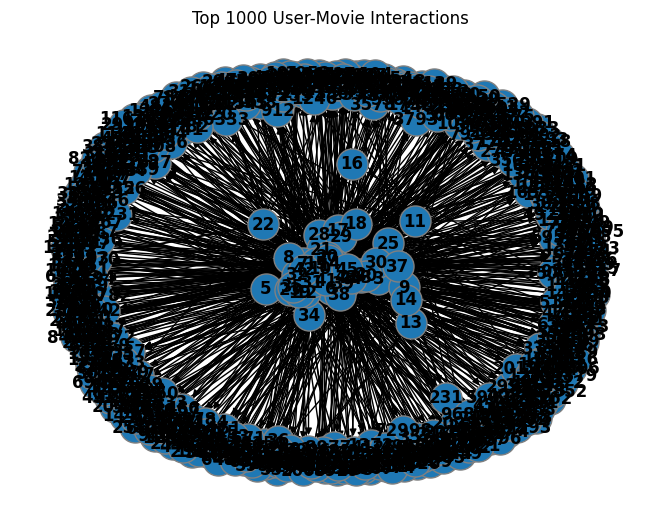

In [96]:
import networkx as nx
# Filter for top 100 interactions
top_interactions = ratings.nlargest(1000, 'rating')

# Create a directed graph for clarity in interactions
G = nx.DiGraph()

# Add nodes with clear labels and colors
G.add_nodes_from(top_interactions['movieId'], bipartite=0, label='Movie', color='lightblue')
G.add_nodes_from(top_interactions['userId'], bipartite=1, label='User', color='lightgreen')

# Add edges with clear labels and weights
edges_ratings = list(zip(top_interactions['userId'], top_interactions['movieId'], top_interactions['rating']))
G.add_weighted_edges_from(edges_ratings, weight='rating', label='rated')

# Visualize the graph with clear labels and layout
pos = nx.spring_layout(G, k=0.4)  # Adjust k for spacing
nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=500, edgecolors='gray')

# Customize edge labels for clarity
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.title("Top 1000 User-Movie Interactions")
plt.show()


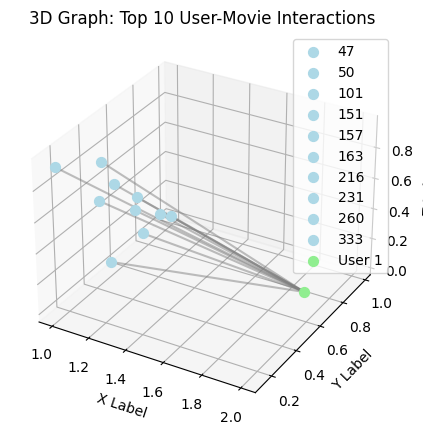

In [59]:

# Assuming you have the necessary data loaded and defined

# Filter for top 10 interactions
top_interactions = ratings.nlargest(10, 'rating')

# Create a directed graph
G = nx.DiGraph()

# Add nodes with clear labels and colors
G.add_nodes_from(top_interactions['movieId'], bipartite=0, label='Movie', color='lightblue')
G.add_nodes_from(top_interactions['userId'], bipartite=1, label='User', color='lightgreen')

# Add edges with clear labels and weights
edges_ratings = list(zip(top_interactions['userId'], top_interactions['movieId'], top_interactions['rating']))
G.add_weighted_edges_from(edges_ratings, weight='rating', label='rated')

# Set positions for nodes (3D layout)
pos = {}
for node in G.nodes:
    if G.nodes[node]['bipartite'] == 0:  # Movie
        pos[node] = (1, random.uniform(0, 1), random.uniform(0, 1))
    else:  # User
        pos[node] = (2, random.uniform(0, 1), random.uniform(0, 1))

# Plot the 3D graph
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

# Draw nodes with labels
for node, (x, y, z) in pos.items():
    label = node if G.nodes[node]['bipartite'] == 0 else f"User {node}"
    color = 'lightblue' if G.nodes[node]['bipartite'] == 0 else 'lightgreen'
    ax.scatter(x, y, z, color=color, s=50, label=label)

# Draw edges
for edge in G.edges:
    x = [pos[edge[0]][0], pos[edge[1]][0]]
    y = [pos[edge[0]][1], pos[edge[1]][1]]
    z = [pos[edge[0]][2], pos[edge[1]][2]]
    ax.plot(x, y, z, color='gray', alpha=0.5)

# Set labels for axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# Set legend
ax.legend()

# Display the 3D graph
plt.title('3D Graph: Top 10 User-Movie Interactions')
plt.show()


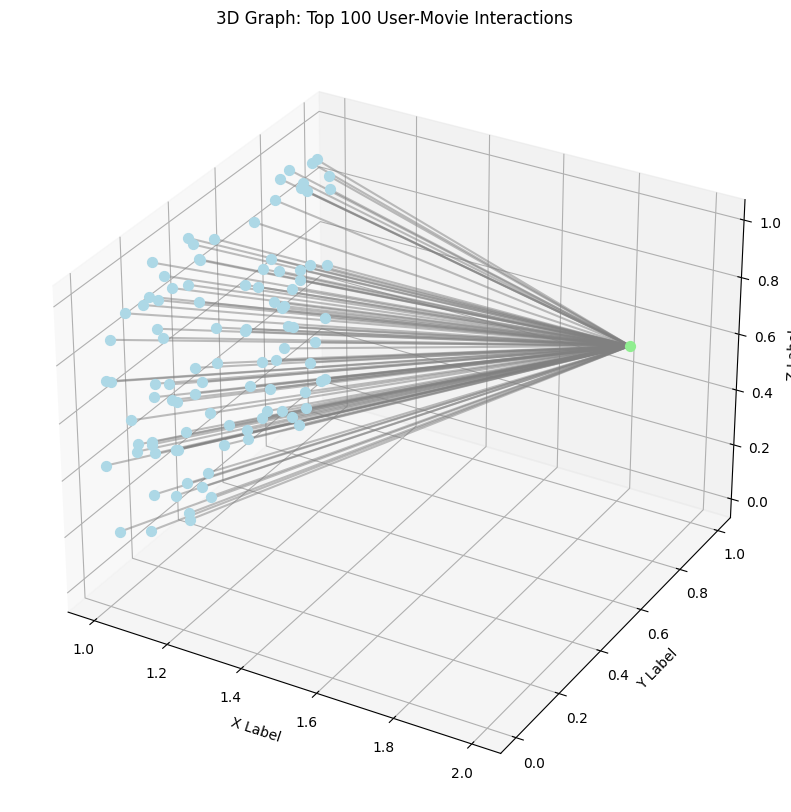

In [97]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import networkx as nx

# Assuming you have the necessary data loaded and defined

# Filter for top 100 interactions
top_interactions = ratings.nlargest(100, 'rating')

# Create a directed graph
G = nx.DiGraph()

# Add nodes
G.add_nodes_from(top_interactions['movieId'], bipartite=0)
G.add_nodes_from(top_interactions['userId'], bipartite=1)

# Add edges with weights
edges_ratings = list(zip(top_interactions['userId'], top_interactions['movieId'], top_interactions['rating']))
G.add_weighted_edges_from(edges_ratings, weight='rating')

# Set positions for nodes (3D layout)
pos = {}
for node in G.nodes:
    if G.nodes[node]['bipartite'] == 0:  # Movie
        pos[node] = (1, random.uniform(0, 1), random.uniform(0, 1))
    else:  # User
        pos[node] = (2, random.uniform(0, 1), random.uniform(0, 1))

# Plot the 3D graph
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Draw nodes
for node, (x, y, z) in pos.items():
    color = 'lightblue' if G.nodes[node]['bipartite'] == 0 else 'lightgreen'
    ax.scatter(x, y, z, color=color, s=50)

# Draw edges
for edge in G.edges:
    x = [pos[edge[0]][0], pos[edge[1]][0]]
    y = [pos[edge[0]][1], pos[edge[1]][1]]
    z = [pos[edge[0]][2], pos[edge[1]][2]]
    ax.plot(x, y, z, color='gray', alpha=0.5)

# Set labels for axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# Display the 3D graph
plt.title('3D Graph: Top 100 User-Movie Interactions')
plt.show()


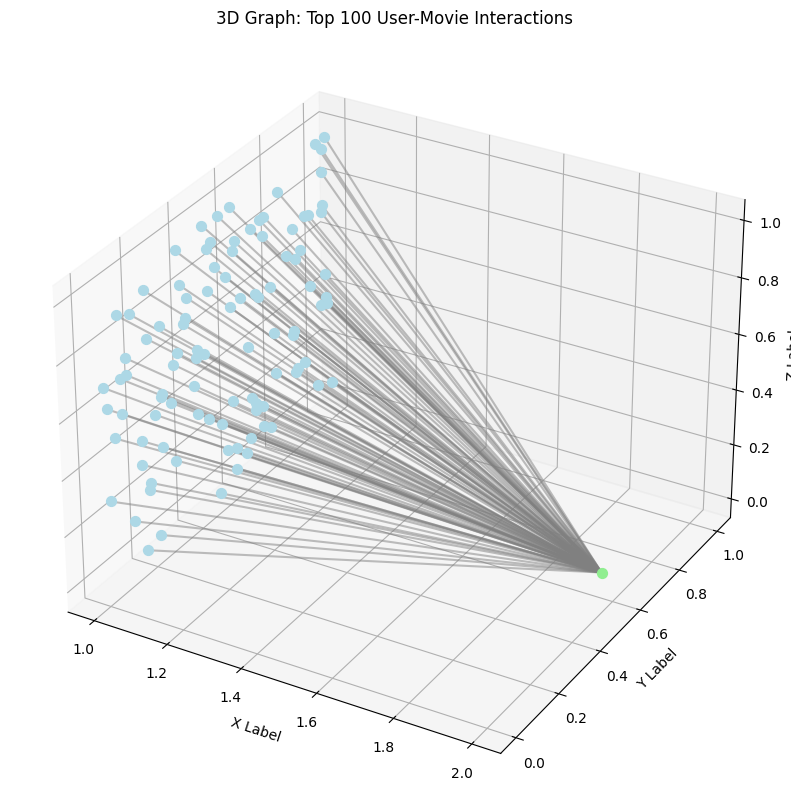

In [61]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import networkx as nx

# Assuming you have the necessary data loaded and defined

# Filter for top 100 interactions
top_interactions = ratings.nlargest(100, 'rating')

# Create a directed graph
G = nx.DiGraph()

# Add nodes
G.add_nodes_from(top_interactions['movieId'], bipartite=0)
G.add_nodes_from(top_interactions['userId'], bipartite=1)

# Add edges with weights
edges_ratings = list(zip(top_interactions['userId'], top_interactions['movieId'], top_interactions['rating']))
G.add_weighted_edges_from(edges_ratings, weight='rating')

# Set positions for nodes (3D layout)
pos = {}
for node in G.nodes:
    if G.nodes[node]['bipartite'] == 0:  # Movie
        pos[node] = (1, random.uniform(0, 1), random.uniform(0, 1))
    else:  # User
        pos[node] = (2, random.uniform(0, 1), random.uniform(0, 1))

# Plot the 3D graph
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Draw nodes
for node, (x, y, z) in pos.items():
    color = 'lightblue' if G.nodes[node]['bipartite'] == 0 else 'lightgreen'
    ax.scatter(x, y, z, color=color, s=50)

# Draw edges
for edge in G.edges:
    x = [pos[edge[0]][0], pos[edge[1]][0]]
    y = [pos[edge[0]][1], pos[edge[1]][1]]
    z = [pos[edge[0]][2], pos[edge[1]][2]]
    ax.plot(x, y, z, color='gray', alpha=0.5)

# Set labels for axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# Display the 3D graph
plt.title('3D Graph: Top 100 User-Movie Interactions')
plt.show()


#GCN

In [17]:
# load user and movie nodes
def load_node_csv(path, index_col):
    """Loads csv containing node information

    Args:
        path (str): path to csv file
        index_col (str): column name of index column

    Returns:
        dict: mapping of csv row to node id
    """
    df = pd.read_csv(path, index_col=index_col)
    mapping = {index: i for i, index in enumerate(df.index.unique())}
    return mapping


user_mapping = load_node_csv(rating_path, index_col='userId')
movie_mapping = load_node_csv(movie_path, index_col='movieId')

In [18]:
def load_edge_csv(path, src_index_col, src_mapping, dst_index_col, dst_mapping, link_index_col, rating_threshold=4):
    """Loads csv containing edges between users and items

    Args:
        path (str): path to csv file
        src_index_col (str): column name of users
        src_mapping (dict): mapping between row number and user id
        dst_index_col (str): column name of items
        dst_mapping (dict): mapping between row number and item id
        link_index_col (str): column name of user item interaction
        rating_threshold (int, optional): Threshold to determine positivity of edge. Defaults to 4.

    Returns:
        torch.Tensor: 2 by N matrix containing the node ids of N user-item edges
    """
    df = pd.read_csv(path)
    edge_index = None
    src = [src_mapping[index] for index in df[src_index_col]]
    dst = [dst_mapping[index] for index in df[dst_index_col]]
    edge_attr = torch.from_numpy(df[link_index_col].values).view(-1, 1).to(torch.long) >= rating_threshold


    edge_index = [[], []]
    for i in range(edge_attr.shape[0]):
        if edge_attr[i]:
            edge_index[0].append(src[i])
            edge_index[1].append(dst[i])

    return torch.tensor(edge_index)


edge_index = load_edge_csv(
    rating_path,
    src_index_col='userId',
    src_mapping=user_mapping,
    dst_index_col='movieId',
    dst_mapping=movie_mapping,
    link_index_col='rating',
    rating_threshold=4,
)

In [19]:
edge_index = torch.LongTensor(edge_index)
print(edge_index)
print(edge_index.size())

tensor([[   0,    0,    0,  ...,  609,  609,  609],
        [   0,    2,    5,  ..., 9461, 9462, 9463]])
torch.Size([2, 48580])


In [20]:
# split the edges of the graph using a 80/10/10 train/validation/test split
num_users, num_movies = len(user_mapping), len(movie_mapping)
num_interactions = edge_index.shape[1]
all_indices = [i for i in range(num_interactions)]

train_indices, test_indices = train_test_split(
    all_indices, test_size=0.2, random_state=1)
val_indices, test_indices = train_test_split(
    test_indices, test_size=0.5, random_state=1)

train_edge_index = edge_index[:, train_indices]
val_edge_index = edge_index[:, val_indices]
test_edge_index = edge_index[:, test_indices]

In [21]:
print(f"num_users {num_users}, num_movies {num_movies}, num_interactions {num_interactions}")
print(f"train_edge_index {train_edge_index}")
print((num_users + num_movies))
print(torch.unique(train_edge_index[0]).size())
print(torch.unique(train_edge_index[1]).size())

num_users 610, num_movies 9742, num_interactions 48580
train_edge_index tensor([[ 605,  110,  442,  ...,   65,  161,  427],
        [1111, 9637, 1284,  ..., 4648,  443,  828]])
10352
torch.Size([609])
torch.Size([5676])


In [22]:
def convert_r_mat_edge_index_to_adj_mat_edge_index(input_edge_index):
    R = torch.zeros((num_users, num_movies))
    for i in range(len(input_edge_index[0])):
        row_idx = input_edge_index[0][i]
        col_idx = input_edge_index[1][i]
        R[row_idx][col_idx] = 1

    R_transpose = torch.transpose(R, 0, 1)
    adj_mat = torch.zeros((num_users + num_movies , num_users + num_movies))
    adj_mat[: num_users, num_users :] = R.clone()
    adj_mat[num_users :, : num_users] = R_transpose.clone()
    adj_mat_coo = adj_mat.to_sparse_coo()
    adj_mat_coo = adj_mat_coo.indices()
    return adj_mat_coo'''

'def convert_r_mat_edge_index_to_adj_mat_edge_index(input_edge_index):\n    R = torch.zeros((num_users, num_movies))\n    for i in range(len(input_edge_index[0])):\n        row_idx = input_edge_index[0][i]\n        col_idx = input_edge_index[1][i]\n        R[row_idx][col_idx] = 1\n\n    R_transpose = torch.transpose(R, 0, 1)\n    adj_mat = torch.zeros((num_users + num_movies , num_users + num_movies))\n    adj_mat[: num_users, num_users :] = R.clone()\n    adj_mat[num_users :, : num_users] = R_transpose.clone()\n    adj_mat_coo = adj_mat.to_sparse_coo()\n    adj_mat_coo = adj_mat_coo.indices()\n    return adj_mat_coo'

In [23]:
def convert_adj_mat_edge_index_to_r_mat_edge_index(input_edge_index):
    sparse_input_edge_index = SparseTensor(row=input_edge_index[0],
                                           col=input_edge_index[1],
                                           sparse_sizes=((num_users + num_movies), num_users + num_movies))
    adj_mat = sparse_input_edge_index.to_dense()
    interact_mat = adj_mat[: num_users, num_users :]
    r_mat_edge_index = interact_mat.to_sparse_coo().indices()
    return r_mat_edge_index

In [24]:
# convert edge indices into Sparse Tensors: https://pytorch-geometric.readthedocs.io/en/latest/notes/sparse_tensor.html
train_sparse_edge_index = SparseTensor(row=train_edge_index[0], col=train_edge_index[1], sparse_sizes=(
    num_users + num_movies, num_users + num_movies))
val_sparse_edge_index = SparseTensor(row=val_edge_index[0], col=val_edge_index[1], sparse_sizes=(
    num_users + num_movies, num_users + num_movies))
test_sparse_edge_index = SparseTensor(row=test_edge_index[0], col=test_edge_index[1], sparse_sizes=(
    num_users + num_movies, num_users + num_movies))

In [25]:
print(train_sparse_edge_index)

SparseTensor(row=tensor([  0,   0,   0,  ..., 609, 609, 609]),
             col=tensor([   0,    2,   43,  ..., 9461, 9462, 9463]),
             size=(10352, 10352), nnz=38864, density=0.04%)


In [26]:
print(val_sparse_edge_index)

SparseTensor(row=tensor([  0,   0,   0,  ..., 609, 609, 609]),
             col=tensor([   5,  184, 1401,  ..., 8570, 8696, 8811]),
             size=(10352, 10352), nnz=4858, density=0.00%)


In [27]:
print(test_sparse_edge_index)

SparseTensor(row=tensor([  0,   0,   0,  ..., 609, 609, 609]),
             col=tensor([ 201,  476,  485,  ..., 9127, 9433, 9434]),
             size=(10352, 10352), nnz=4858, density=0.00%)


## Bayesian Personalized Ranking loss (BPR loss)

To train the LightGCN model, we need an objective function that aligns with our goal for movie recommendation. We use the Bayesian Personalized Ranking (BPR) loss, which encourages observed user-item predictions to have increasingly higher values than unobserved ones, along with $ L_2 $ regularization:
$$ L_{BPR} = - \sum_{u=1}^M \sum_{i \in N_u} \sum_{j \notin N_u} \ln \sigma(\hat{y}_{ui} - \hat{y}_{uj}) + \lambda ||\textbf{E}^{(0)} ||^2 $$
where $ \textbf{E}^{(0)} $ is a matrix with column vectors being the 0-th layer embeddings to learn.

In [28]:
def bpr_loss(users_emb_final, users_emb_0, pos_items_emb_final, pos_items_emb_0, neg_items_emb_final, neg_items_emb_0, lambda_val):
    """Bayesian Personalized Ranking Loss

    Args:
        users_emb_final (torch.Tensor): e_u_k
        users_emb_0 (torch.Tensor): e_u_0
        pos_items_emb_final (torch.Tensor): positive e_i_k
        pos_items_emb_0 (torch.Tensor): positive e_i_0
        neg_items_emb_final (torch.Tensor): negative e_i_k
        neg_items_emb_0 (torch.Tensor): negative e_i_0
        lambda_val (float): lambda value for regularization loss term

    Returns:
        torch.Tensor: scalar bpr loss value
    """
    reg_loss = lambda_val * (users_emb_0.norm(2).pow(2) +
                             pos_items_emb_0.norm(2).pow(2) +
                             neg_items_emb_0.norm(2).pow(2)) # L2 loss

    pos_scores = torch.mul(users_emb_final, pos_items_emb_final)
    pos_scores = torch.sum(pos_scores, dim=-1) # predicted scores of positive samples
    neg_scores = torch.mul(users_emb_final, neg_items_emb_final)
    neg_scores = torch.sum(neg_scores, dim=-1) # predicted scores of negative samples

    loss = -torch.mean(torch.nn.functional.softplus(pos_scores - neg_scores)) + reg_loss

    return loss

In [29]:
def sample_mini_batch(batch_size, edge_index):
    """Randomly samples indices of a minibatch given an adjacency matrix

    Args:
        batch_size (int): minibatch size
        edge_index (torch.Tensor): 2 by N list of edges

    Returns:
        tuple: user indices, positive item indices, negative item indices
    """
    edges = structured_negative_sampling(edge_index)
    edges = torch.stack(edges, dim=0)
    indices = random.choices(
        [i for i in range(edges[0].shape[0])], k=batch_size)
    batch = edges[:, indices]
    user_indices, pos_item_indices, neg_item_indices = batch[0], batch[1], batch[2]
    return user_indices, pos_item_indices, neg_item_indices

## LightGCN neiborhood aggregation layer

Starting with the initial embeddings $E^{(0)}$ and the bipartite graph, we iterate over each node to perform neighborhood aggregation. Note that LightGCN uses **a simple weighted sum aggregator** and **avoids the heavy-lifting feature transformation and nonlinear activation**.

Within each layer, for each user in the graph, we compute its updated embedding as the weighted sum of embeddings from all its neighboring items (movies) following the formula below:
$$ \textbf{e}_u^{(k+1)} = \sum_{i \in N_u} \frac{1}{\sqrt{|N_u|} \sqrt{|N_i|}} \textbf{e}_i^{(k)} $$
where $ \textbf{e}_u^{(k)} $ and $ \textbf{e}_i^{(k)} $ are the user and item (movie) node embeddings at the k-th layer. $ |N_u| $ and $ |N_i| $ are the user and item nodes’ number of neighbors.

Similarly, for each item, the updated embedding is computed using weighted sum of its neighboring users:
$$ \textbf{e}_i^{(k+1)} = \sum_{i \in N_i} \frac{1}{\sqrt{|N_i|} \sqrt{|N_u|}} \textbf{e}_u^{(k)} $$

In [30]:
class LightGCN(MessagePassing):
    """LightGCN Model
    """

    def __init__(self, num_users, num_items, embedding_dim=64, K=3, add_self_loops=False):
        """Initializes LightGCN Model

        Args:
            num_users (int): Number of users
            num_items (int): Number of items
            embedding_dim (int, optional): Dimensionality of embeddings. Defaults to 8.
            K (int, optional): Number of message passing layers. Defaults to 3.
            add_self_loops (bool, optional): Whether to add self loops for message passing. Defaults to False.
        """
        super().__init__()
        self.num_users, self.num_items = num_users, num_items
        self.embedding_dim, self.K = embedding_dim, K
        self.add_self_loops = add_self_loops

        self.users_emb = nn.Embedding(
            num_embeddings=self.num_users, embedding_dim=self.embedding_dim) # e_u^0
        self.items_emb = nn.Embedding(
            num_embeddings=self.num_items, embedding_dim=self.embedding_dim) # e_i^0

        nn.init.normal_(self.users_emb.weight, std=0.1)
        nn.init.normal_(self.items_emb.weight, std=0.1)

    def forward(self, edge_index: SparseTensor):
        """Forward propagation of LightGCN Model.

        Args:
            edge_index (SparseTensor): adjacency matrix

        Returns:
            tuple (Tensor): e_u_k, e_u_0, e_i_k, e_i_0
        """
        # compute \tilde{A}: symmetrically normalized adjacency matrix
        edge_index_norm = gcn_norm(
            edge_index, add_self_loops=self.add_self_loops)

        emb_0 = torch.cat([self.users_emb.weight, self.items_emb.weight]) # E^0
        embs = [emb_0]
        emb_k = emb_0

        # multi-scale diffusion
        for i in range(self.K):
            emb_k = self.propagate(edge_index_norm, x=emb_k)
            embs.append(emb_k)

        embs = torch.stack(embs, dim=1)
        emb_final = torch.mean(embs, dim=1) # E^K

        users_emb_final, items_emb_final = torch.split(
            emb_final, [self.num_users, self.num_items]) # splits into e_u^K and e_i^K

        # returns e_u^K, e_u^0, e_i^K, e_i^0
        return users_emb_final, self.users_emb.weight, items_emb_final, self.items_emb.weight

    def message(self, x_j: Tensor) -> Tensor:
        return x_j

    def message_and_aggregate(self, adj_t: SparseTensor, x: Tensor) -> Tensor:
        # computes \tilde{A} @ x
        return matmul(adj_t, x)

model = LightGCN(num_users, num_movies)



In [31]:
def get_user_positive_items(edge_index):
    """Generates dictionary of positive items for each user

    Args:
        edge_index (torch.Tensor): 2 by N list of edges

    Returns:
        dict: dictionary of positive items for each user
    """
    user_pos_items = {}
    for i in range(edge_index.shape[1]):
        user = edge_index[0][i].item()
        item = edge_index[1][i].item()
        if user not in user_pos_items:
            user_pos_items[user] = []
        user_pos_items[user].append(item)
    return user_pos_items

In [32]:
def RecallPrecision_ATk(groundTruth, r, k):
    """Computers recall @ k and precision @ k

    Args:
        groundTruth (list): list of lists containing highly rated items of each user
        r (list): list of lists indicating whether each top k item recommended to each user
            is a top k ground truth item or not
        k (intg): determines the top k items to compute precision and recall on

    Returns:
        tuple: recall @ k, precision @ k
    """
    num_correct_pred = torch.sum(r, dim=-1)  # number of correctly predicted items per user
    # number of items liked by each user in the test set
    user_num_liked = torch.Tensor([len(groundTruth[i])
                                  for i in range(len(groundTruth))])
    recall = torch.mean(num_correct_pred / user_num_liked)
    precision = torch.mean(num_correct_pred) / k
    return recall.item(), precision.item()

In [33]:
def NDCGatK_r(groundTruth, r, k):
    """Computes Normalized Discounted Cumulative Gain (NDCG) @ k

    Args:
        groundTruth (list): list of lists containing highly rated items of each user
        r (list): list of lists indicating whether each top k item recommended to each user
            is a top k ground truth item or not
        k (int): determines the top k items to compute ndcg on

    Returns:
        float: ndcg @ k
    """
    assert len(r) == len(groundTruth)

    test_matrix = torch.zeros((len(r), k))

    for i, items in enumerate(groundTruth):
        length = min(len(items), k)
        test_matrix[i, :length] = 1
    max_r = test_matrix
    idcg = torch.sum(max_r * 1. / torch.log2(torch.arange(2, k + 2)), axis=1)
    dcg = r * (1. / torch.log2(torch.arange(2, k + 2)))
    dcg = torch.sum(dcg, axis=1)
    idcg[idcg == 0.] = 1.
    ndcg = dcg / idcg
    ndcg[torch.isnan(ndcg)] = 0.
    return torch.mean(ndcg).item()

In [34]:
def get_metrics(model, edge_index, exclude_edge_indices, k):
    """Computes the evaluation metrics: recall, precision, and ndcg @ k

    Args:
        model (LighGCN): lightgcn model
        edge_index (torch.Tensor): 2 by N list of edges for split to evaluate
        exclude_edge_indices ([type]): 2 by N list of edges for split to discount from evaluation
        k (int): determines the top k items to compute metrics on

    Returns:
        tuple: recall @ k, precision @ k, ndcg @ k
    """
    user_embedding = model.users_emb.weight
    item_embedding = model.items_emb.weight

    # get ratings between every user and item - shape is num users x num movies
    rating = torch.matmul(user_embedding, item_embedding.T)

    for exclude_edge_index in exclude_edge_indices:
        # gets all the positive items for each user from the edge index
        user_pos_items = get_user_positive_items(exclude_edge_index)
        # get coordinates of all edges to exclude
        exclude_users = []
        exclude_items = []
        for user, items in user_pos_items.items():
            exclude_users.extend([user] * len(items))
            exclude_items.extend(items)

        # set ratings of excluded edges to large negative value
        rating[exclude_users, exclude_items] = -(1 << 10)

    # get the top k recommended items for each user
    _, top_K_items = torch.topk(rating, k=k)

    # get all unique users in evaluated split
    users = edge_index[0].unique()

    test_user_pos_items = get_user_positive_items(edge_index)

    # convert test user pos items dictionary into a list
    test_user_pos_items_list = [
        test_user_pos_items[user.item()] for user in users]

    # determine the correctness of topk predictions
    r = []
    for user in users:
        ground_truth_items = test_user_pos_items[user.item()]
        label = list(map(lambda x: x in ground_truth_items, top_K_items[user]))
        r.append(label)
    r = torch.Tensor(np.array(r).astype('float'))

    recall, precision = RecallPrecision_ATk(test_user_pos_items_list, r, k)
    ndcg = NDCGatK_r(test_user_pos_items_list, r, k)

    return recall, precision, ndcg

In [35]:
def evaluation(model, edge_index, sparse_edge_index, exclude_edge_indices, k, lambda_val):
    """Evaluates model loss and metrics including recall, precision, ndcg @ k

    Args:
        model (LighGCN): lightgcn model
        edge_index (torch.Tensor): 2 by N list of edges for split to evaluate
        sparse_edge_index (sparseTensor): sparse adjacency matrix for split to evaluate
        exclude_edge_indices ([type]): 2 by N list of edges for split to discount from evaluation
        k (int): determines the top k items to compute metrics on
        lambda_val (float): determines lambda for bpr loss

    Returns:
        tuple: bpr loss, recall @ k, precision @ k, ndcg @ k
    """
    # get embeddings
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(
        sparse_edge_index)
    edges = structured_negative_sampling(
        edge_index, contains_neg_self_loops=False)
    user_indices, pos_item_indices, neg_item_indices = edges[0], edges[1], edges[2]
    users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
    pos_items_emb_final, pos_items_emb_0 = items_emb_final[
        pos_item_indices], items_emb_0[pos_item_indices]
    neg_items_emb_final, neg_items_emb_0 = items_emb_final[
        neg_item_indices], items_emb_0[neg_item_indices]

    loss = bpr_loss(users_emb_final, users_emb_0, pos_items_emb_final, pos_items_emb_0,
                    neg_items_emb_final, neg_items_emb_0, lambda_val).item()

    recall, precision, ndcg = get_metrics(
        model, edge_index, exclude_edge_indices, k)

    return loss, recall, precision, ndcg

#Model Training and Testing

In [36]:
ITERATIONS = 10000
BATCH_SIZE = 1024
LR = 1e-3
ITERS_PER_EVAL = 200
ITERS_PER_LR_DECAY = 200
K = 2
LAMBDA = 1e-6

In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device {device}.")


model = model.to(device)
model.train()

optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

edge_index = edge_index.to(device)
train_edge_index = train_edge_index.to(device)
train_sparse_edge_index = train_sparse_edge_index.to(device)

val_edge_index = val_edge_index.to(device)
val_sparse_edge_index = val_sparse_edge_index.to(device)

Using device cpu.


In [38]:
train_losses = []
val_losses = []

for iter in range(ITERATIONS):
    # forward propagation
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(
        train_sparse_edge_index)

    # mini batching
    user_indices, pos_item_indices, neg_item_indices = sample_mini_batch(
        BATCH_SIZE, train_edge_index)
    user_indices, pos_item_indices, neg_item_indices = user_indices.to(
        device), pos_item_indices.to(device), neg_item_indices.to(device)
    users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
    pos_items_emb_final, pos_items_emb_0 = items_emb_final[
        pos_item_indices], items_emb_0[pos_item_indices]
    neg_items_emb_final, neg_items_emb_0 = items_emb_final[
        neg_item_indices], items_emb_0[neg_item_indices]

    # loss computation
    train_loss = bpr_loss(users_emb_final, users_emb_0, pos_items_emb_final,
                          pos_items_emb_0, neg_items_emb_final, neg_items_emb_0, LAMBDA)

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    if iter % ITERS_PER_EVAL == 0:
        model.eval()
        val_loss, recall, precision, ndcg = evaluation(
            model, val_edge_index, val_sparse_edge_index, [train_edge_index], K, LAMBDA)
        print(f"[Iteration {iter}/{ITERATIONS}] train_loss: {round(train_loss.item(), 5)}, val_loss: {round(val_loss, 5)}, val_recall@{K}: {round(recall, 5)}, val_precision@{K}: {round(precision, 5)}, val_ndcg@{K}: {round(ndcg, 5)}")
        train_losses.append(train_loss.item())
        val_losses.append(val_loss)
        model.train()

    if iter % ITERS_PER_LR_DECAY == 0 and iter != 0:
        scheduler.step()

[Iteration 0/10000] train_loss: -0.69109, val_loss: -0.68381, val_recall@2: 4e-05, val_precision@2: 0.0009, val_ndcg@2: 0.0007
[Iteration 200/10000] train_loss: -0.70033, val_loss: -0.69027, val_recall@2: 0.00846, val_precision@2: 0.02712, val_ndcg@2: 0.02987
[Iteration 400/10000] train_loss: -0.89431, val_loss: -0.83523, val_recall@2: 0.03179, val_precision@2: 0.08228, val_ndcg@2: 0.09022
[Iteration 600/10000] train_loss: -1.89498, val_loss: -1.56132, val_recall@2: 0.02996, val_precision@2: 0.08137, val_ndcg@2: 0.08845
[Iteration 800/10000] train_loss: -3.46002, val_loss: -2.90928, val_recall@2: 0.02902, val_precision@2: 0.07776, val_ndcg@2: 0.08524
[Iteration 1000/10000] train_loss: -5.3198, val_loss: -4.57091, val_recall@2: 0.02986, val_precision@2: 0.08409, val_ndcg@2: 0.09055
[Iteration 1200/10000] train_loss: -7.97236, val_loss: -6.3513, val_recall@2: 0.02978, val_precision@2: 0.08409, val_ndcg@2: 0.09055
[Iteration 1400/10000] train_loss: -10.35505, val_loss: -8.33961, val_recal

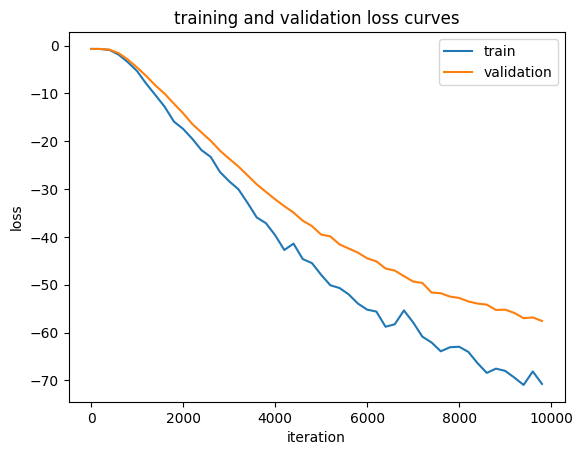

In [39]:
iters = [iter * ITERS_PER_EVAL for iter in range(len(train_losses))]
plt.plot(iters, train_losses, label='train')
plt.plot(iters, val_losses, label='validation')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('training and validation loss curves')
plt.legend()
plt.show()

In [106]:
torch.save(model.state_dict(), 'trained_model.pth')

In [40]:
model.eval()
test_edge_index = test_edge_index.to(device)
test_sparse_edge_index = test_sparse_edge_index.to(device)

test_loss, test_recall, test_precision, test_ndcg = evaluation(
            model, test_edge_index, test_sparse_edge_index, [train_edge_index, val_edge_index], K, LAMBDA)

print(f"[test_loss: {round(test_loss, 5)}, test_recall@{K}: {round(test_recall, 5)}, test_precision@{K}: {round(test_precision, 5)}, test_ndcg@{K}: {round(test_ndcg, 5)}]")


[test_loss: -51.55753, test_recall@2: 0.02794, test_precision@2: 0.08877, test_ndcg@2: 0.09196]


In [41]:
model.eval()
df = pd.read_csv(movie_path)
movieid_title = pd.Series(df.title.values,index=df.movieId).to_dict()
movieid_genres = pd.Series(df.genres.values,index=df.movieId).to_dict()

user_pos_items = get_user_positive_items(edge_index)

In [42]:
USER_ID = 1
NUM_RECS = 10

user = user_mapping[USER_ID]
e_u = model.users_emb.weight[user]
scores = model.items_emb.weight @ e_u

values, indices = torch.topk(scores, k=len(user_pos_items[user]) + NUM_RECS)

movies = [index.cpu().item() for index in indices if index in user_pos_items[user]][:NUM_RECS]
movie_ids = [list(movie_mapping.keys())[list(movie_mapping.values()).index(movie)] for movie in movies]
titles = [movieid_title[id] for id in movie_ids]
genres = [movieid_genres[id] for id in movie_ids]

print(f"Here are some movies that user {USER_ID} rated highly")
for i in range(NUM_RECS):
    print(f"title: {titles[i]}, genres: {genres[i]} ")

print()

movies = [index.cpu().item() for index in indices if index not in user_pos_items[user]][:NUM_RECS]
movie_ids = [list(movie_mapping.keys())[list(movie_mapping.values()).index(movie)] for movie in movies]
titles = [movieid_title[id] for id in movie_ids]
genres = [movieid_genres[id] for id in movie_ids]

print(f"Here are some suggested movies for user {USER_ID}")
for i in range(NUM_RECS):
    print(f"title: {titles[i]}, genres: {genres[i]} ")

Here are some movies that user 1 rated highly
title: Forrest Gump (1994), genres: Comedy|Drama|Romance|War 
title: Matrix, The (1999), genres: Action|Sci-Fi|Thriller 
title: Star Wars: Episode IV - A New Hope (1977), genres: Action|Adventure|Sci-Fi 
title: Silence of the Lambs, The (1991), genres: Crime|Horror|Thriller 
title: Fight Club (1999), genres: Action|Crime|Drama|Thriller 
title: Schindler's List (1993), genres: Drama|War 
title: Star Wars: Episode V - The Empire Strikes Back (1980), genres: Action|Adventure|Sci-Fi 
title: Braveheart (1995), genres: Action|Drama|War 
title: Usual Suspects, The (1995), genres: Crime|Mystery|Thriller 
title: American Beauty (1999), genres: Drama|Romance 

Here are some suggested movies for user 1
title: Shawshank Redemption, The (1994), genres: Crime|Drama 
title: Pulp Fiction (1994), genres: Comedy|Crime|Drama|Thriller 
title: Godfather, The (1972), genres: Crime|Drama 
title: Terminator 2: Judgment Day (1991), genres: Action|Sci-Fi 
title: Lor

In [43]:
USER_ID = 6
NUM_RECS = 10

user = user_mapping[USER_ID]
e_u = model.users_emb.weight[user]
scores = model.items_emb.weight @ e_u

values, indices = torch.topk(scores, k=len(user_pos_items[user]) + NUM_RECS)

movies = [index.cpu().item() for index in indices if index in user_pos_items[user]][:NUM_RECS]
movie_ids = [list(movie_mapping.keys())[list(movie_mapping.values()).index(movie)] for movie in movies]
titles = [movieid_title[id] for id in movie_ids]
genres = [movieid_genres[id] for id in movie_ids]

print(f"Here are some movies that user {USER_ID} rated highly")
for i in range(NUM_RECS):
    print(f"title: {titles[i]}, genres: {genres[i]} ")

print()

movies = [index.cpu().item() for index in indices if index not in user_pos_items[user]][:NUM_RECS]
movie_ids = [list(movie_mapping.keys())[list(movie_mapping.values()).index(movie)] for movie in movies]
titles = [movieid_title[id] for id in movie_ids]
genres = [movieid_genres[id] for id in movie_ids]

print(f"Here are some suggested movies for user {USER_ID}")
for i in range(NUM_RECS):
    print(f"title: {titles[i]}, genres: {genres[i]} ")

Here are some movies that user 6 rated highly
title: Shawshank Redemption, The (1994), genres: Crime|Drama 
title: Forrest Gump (1994), genres: Comedy|Drama|Romance|War 
title: Silence of the Lambs, The (1991), genres: Crime|Horror|Thriller 
title: Braveheart (1995), genres: Action|Drama|War 
title: Jurassic Park (1993), genres: Action|Adventure|Sci-Fi|Thriller 
title: Seven (a.k.a. Se7en) (1995), genres: Mystery|Thriller 
title: Fugitive, The (1993), genres: Thriller 
title: Apollo 13 (1995), genres: Adventure|Drama|IMAX 
title: Lion King, The (1994), genres: Adventure|Animation|Children|Drama|Musical|IMAX 
title: Aladdin (1992), genres: Adventure|Animation|Children|Comedy|Musical 

Here are some suggested movies for user 6
title: Pulp Fiction (1994), genres: Comedy|Crime|Drama|Thriller 
title: Matrix, The (1999), genres: Action|Sci-Fi|Thriller 
title: Star Wars: Episode IV - A New Hope (1977), genres: Action|Adventure|Sci-Fi 
title: Fight Club (1999), genres: Action|Crime|Drama|Thril

In [99]:
print(f"Length of titles list: {len(titles)}")
print(f"Length of genres list: {len(genres)}")

Length of titles list: 10
Length of genres list: 10


In [100]:
for i in range(min(NUM_RECS, len(titles))):
    print(f"title: {titles[i]}, genres: {genres[i]} ")

title: Pulp Fiction (1994), genres: Comedy|Crime|Drama|Thriller 
title: Matrix, The (1999), genres: Action|Sci-Fi|Thriller 
title: Star Wars: Episode IV - A New Hope (1977), genres: Action|Adventure|Sci-Fi 
title: Fight Club (1999), genres: Action|Crime|Drama|Thriller 
title: Schindler's List (1993), genres: Drama|War 
title: Star Wars: Episode V - The Empire Strikes Back (1980), genres: Action|Adventure|Sci-Fi 
title: Godfather, The (1972), genres: Crime|Drama 
title: Usual Suspects, The (1995), genres: Crime|Mystery|Thriller 
title: American Beauty (1999), genres: Drama|Romance 
title: Star Wars: Episode VI - Return of the Jedi (1983), genres: Action|Adventure|Sci-Fi 


In [101]:
if len(titles) < NUM_RECS:
    print("Not enough highly rated movies for user.")
else:
    for i in range(NUM_RECS):
        print(f"title: {titles[i]}, genres: {genres[i]} ")

title: Pulp Fiction (1994), genres: Comedy|Crime|Drama|Thriller 
title: Matrix, The (1999), genres: Action|Sci-Fi|Thriller 
title: Star Wars: Episode IV - A New Hope (1977), genres: Action|Adventure|Sci-Fi 
title: Fight Club (1999), genres: Action|Crime|Drama|Thriller 
title: Schindler's List (1993), genres: Drama|War 
title: Star Wars: Episode V - The Empire Strikes Back (1980), genres: Action|Adventure|Sci-Fi 
title: Godfather, The (1972), genres: Crime|Drama 
title: Usual Suspects, The (1995), genres: Crime|Mystery|Thriller 
title: American Beauty (1999), genres: Drama|Romance 
title: Star Wars: Episode VI - Return of the Jedi (1983), genres: Action|Adventure|Sci-Fi 


In [47]:
import torch

# Assuming you have defined movie_mapping, movieid_title, movieid_genres, and model

def get_movie_id(movie_name):
    # Function to get the movie ID from its name
    for movie_id, title in movieid_title.items():
        if title == movie_name:
            return movie_id
    return None

def recommend_similar_movies(movie_name, num_recs=10):
    movie_id = get_movie_id(movie_name)
    if movie_id is None:
        print(f"Movie '{movie_name}' not found.")
        return

    # Get the embeddings for the movie
    e_m = model.items_emb.weight[movie_id]

    # Compute similarity scores between the input movie and all other movies
    scores = torch.matmul(model.items_emb.weight, e_m)

    # Get top recommendations
    values, indices = torch.topk(scores, k=num_recs+1)  # +1 to exclude the input movie itself
    recommended_movies = [(index.cpu().item(), value.item()) for index, value in zip(indices, values) if index != movie_id]

    print(f"Movies similar to '{movie_name}':")
    for index, _ in recommended_movies[:num_recs]:
        movie_title = movieid_title.get(index)
        if movie_title:
            print(f"Title: {movie_title}, Genres: {movieid_genres.get(index)}")

# Example usage
movie_input = "Toy Story (1995)"
recommend_similar_movies(movie_input)


Movies similar to 'Toy Story (1995)':
Title: Miracle on 34th Street (1994), Genres: Drama
Title: Secret of Roan Inish, The (1994), Genres: Children|Drama|Fantasy|Mystery
Title: Just Cause (1995), Genres: Mystery|Thriller
Title: Best Years of Our Lives, The (1946), Genres: Drama|War
Title: Don Juan DeMarco (1995), Genres: Comedy|Drama|Romance
Title: Poetic Justice (1993), Genres: Drama
Title: Ring, The (1927), Genres: Drama
Title: Go Fish (1994), Genres: Drama|Romance
Title: Philadelphia Story, The (1940), Genres: Comedy|Drama|Romance
